## [Canny Edge Detection](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

The Canny edge detection algorithm is composed of 5 steps:

1. [Noise reduction](#1-smoothing-to-remove-noise-that-may-cause-false-edges)
2. [Gradient calculation](#2-finding-gradients)
3. [Non-maximum suppression](#3-non-maximum-suppression)
4. [Double threshold](#4-double-thresholding)
5. [Edge Tracking by Hysteresis](#5-edge-tracking-by-hysteresis)

(1067, 1600, 3)

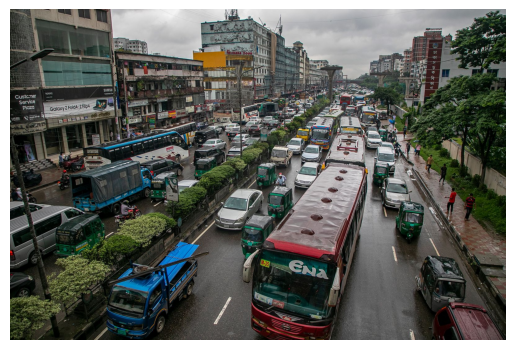

In [28]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy.ndimage import convolve


img = cv2.imread("./assets/traffic.jpg", cv2.IMREAD_COLOR)
img = img.astype(np.float32) / 255.0
img.shape

plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

#### 1. Smoothing to remove noise that may cause false edges.

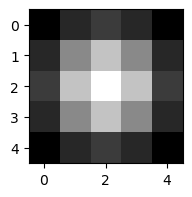

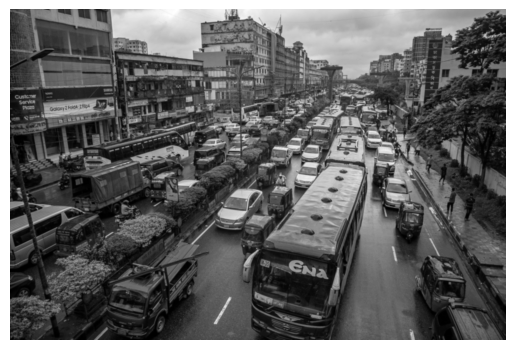

In [29]:
gaussian_blur = np.array([
    [2, 4, 5, 4, 2],
    [4, 9, 12, 9, 4],
    [5, 12, 15, 12, 5],
    [4, 9, 12, 9, 4],
    [2, 4, 5, 4, 2]
], dtype=np.float32) / 159

denoised = convolve(cv2.cvtColor(img * 255, cv2.COLOR_BGR2GRAY), gaussian_blur)

plt.figure(figsize=(2, 2))
plt.imshow(gaussian_blur, cmap='gray')
plt.show()

plt.imshow(denoised, cmap='gray')
plt.axis('off')
plt.show()

### 2. Finding Gradients.

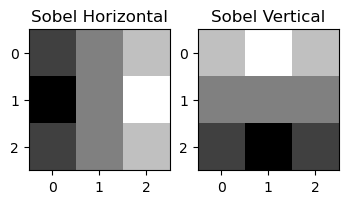

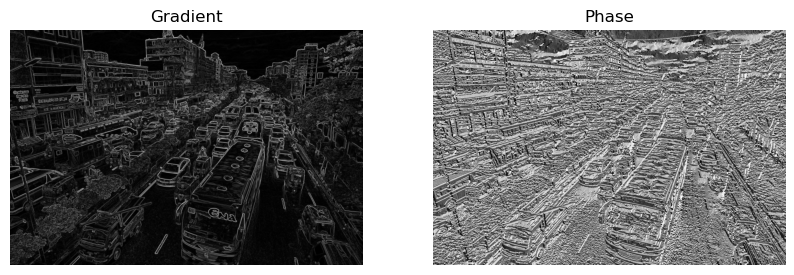

In [30]:

sobel_x = np.array([[ -1 , 0 , 1 ] ,
                    [ -2 , 0 , 2 ] ,
                    [ -1 , 0 , 1 ]], dtype=np.float32)

sobel_y = - sobel_x.T

def gradient_sobel( img ):
    image_sobel_x = convolve( img , sobel_x ).astype(np.float32)
    image_sobel_y = convolve( img , sobel_y ).astype(np.float32)

    gradient = np.hypot(image_sobel_x , image_sobel_y)
    gradient  = gradient / gradient.max() * 255

    phase = np.arctan2(image_sobel_y, image_sobel_x) * (180.0 / np.pi)

    return gradient , phase 


gradient, phase = gradient_sobel(denoised)

_, axs = plt.subplots(1, 2, figsize=(4, 2))
axs[0].imshow(sobel_x, cmap='gray')
axs[0].set_title('Sobel Horizontal')
axs[1].imshow(sobel_y, cmap='gray')
axs[1].set_title('Sobel Vertical')
plt.show()


_, axs = plt.subplots(1, 2, figsize=(10, 15))

axs[0].imshow(gradient, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Gradient')

axs[1].imshow(phase, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Phase')
plt.show()

### 3. Non-maximum suppression.

Text(0.5, 1.0, 'Non-Max Suppression')

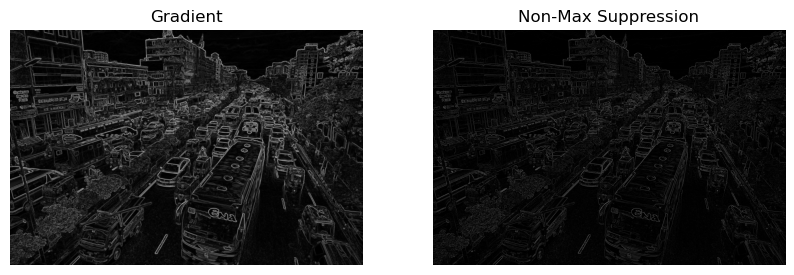

In [31]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = ((45 * np.round(D / 45.0)) + 180) % 180 # {0, 45, 90, 135}
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
                if (angle[i,j] == 0):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (angle[i,j] == 45):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif (angle[i,j] == 90):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (angle[i,j] == 135):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                
            except IndexError as e:
                pass
    
    return Z
gradient_suppressed = non_max_suppression(gradient, phase)

_, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(gradient, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Gradient')

axs[1].imshow(gradient_suppressed, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Non-Max Suppression')

### 4. Double Thresholding.

high 76.5
low 3.825


Text(0.5, 1.0, 'Thresholded')

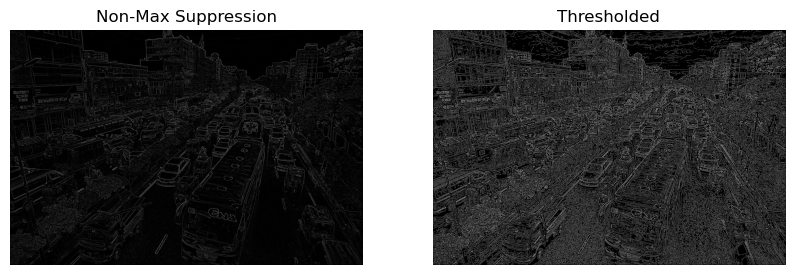

In [32]:
lowThresholdRatio = 0.05
highThresholdRatio = 0.3

highThreshold = gradient_suppressed.max() * highThresholdRatio
lowThreshold = highThreshold * lowThresholdRatio

print('high', highThreshold)
print('low', lowThreshold)

M, N = gradient_suppressed.shape
grad_supp_thresh = np.zeros((M,N), dtype=np.int32)

weak = np.int32(150)
strong = np.int32(255)

grad_supp_thresh[gradient_suppressed >= highThreshold] = strong
grad_supp_thresh[(gradient_suppressed >= lowThreshold) & (gradient_suppressed < highThreshold)] = weak

_, axs = plt.subplots(1, 2, figsize=(10, 15))
axs[0].imshow(gradient_suppressed, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Non-Max Suppression')

axs[1].imshow(grad_supp_thresh, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Thresholded')

### 5. Edge Tracking by Hysteresis.

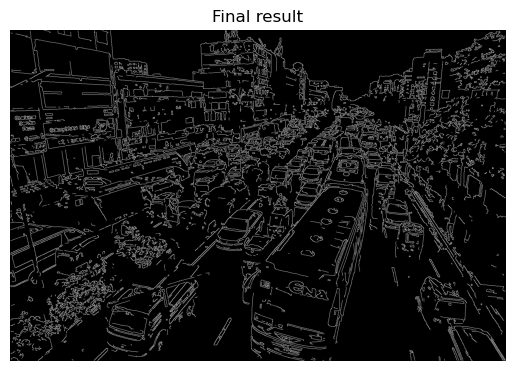

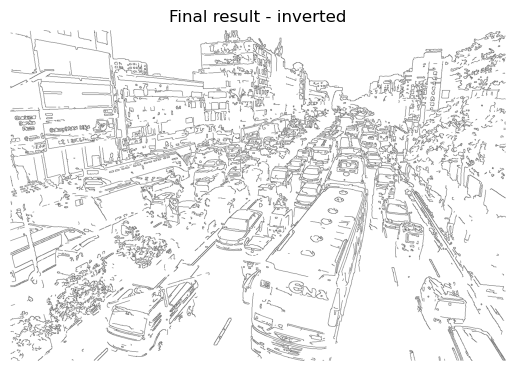

In [33]:
def get_neighbours(i, j):
    return [(i+1, j), (i-1, j), (i, j+1), (i, j-1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]

res = grad_supp_thresh.copy()
M, N = res.shape  
for i in range(1, M-1):
    for j in range(1, N-1):
        if (res[i,j] == weak):
            try:
                if any(res[n] == strong for n in get_neighbours(i, j)):
                    res[i, j] = strong
                else:
                    res[i, j] = 0
            except IndexError as e:
                pass

plt.imshow(res, cmap='gray')
plt.axis('off')
plt.title('Final result')
plt.show()

plt.imshow(255 - res, cmap='gray')
plt.axis('off')
plt.title('Final result - inverted')
plt.show()

References:
- [Canny Edge Detection - Computerwhile](https://www.youtube.com/watch?v=sRFM5IEqR2w)
- [Canny Edge Detector - Computerphile](https://www.youtube.com/watch?v=sRFM5IEqR2w)